<a href="https://colab.research.google.com/github/grazder/dul_2021/blob/hw3/Homework3_autoregressive_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 130 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 30.10 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=500159e821fa0535be261b9971bb3dd2200eedbde0362424f4aed38992fc5607
  Stored in directory: /tmp/pip-ephem-wheel-cache-tmfakpm5/wheels/55/59/29/0fb1c63565215773

In [2]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


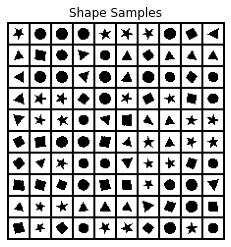

In [3]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MaskConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))

    def forward(self, x):
        self.weight.data *= self.mask
        out = super(MaskConv, self).forward(x)
        return out


class ConvA(MaskConv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mask[:, :, self.kernel_size[0] // 2, :self.kernel_size[1] // 2] = 1
        self.mask[:, :, :self.kernel_size[0] // 2] = 1
    

class ConvB(MaskConv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        h, w = self.kernel_size
        self.mask[:, :, self.kernel_size[0] // 2, :self.kernel_size[1] // 2 + 1] = 1
        self.mask[:, :, :self.kernel_size[0] // 2] = 1

In [6]:
class Residual(nn.Module):
    def __init__(self, in_channels):
      super().__init__()

      self.model = nn.Sequential(
          ConvB(in_channels=in_channels, out_channels=in_channels // 2, kernel_size=1),
          nn.ReLU(),
          ConvB(in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=7, padding=3),
          nn.ReLU(),
          ConvB(in_channels=in_channels // 2, out_channels=in_channels, kernel_size=1)
      )

    def forward(self, x):
        out = torch.clone(x)
        out = self.model(out)
        return out + x

In [24]:
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from scipy.optimize import bisect


class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_filters=120, n_layers=8, gauss_number=10):
        
        super().__init__()
        self.h, self.w, self.c = input_shape
        self.gauss_number = gauss_number

        layers = [ConvA(self.c, n_filters, kernel_size=7, padding=3)]
        layers += [Residual(n_filters) for _ in range(n_layers)]
        layers += [
            nn.ReLU(),
            ConvB(in_channels=n_filters, out_channels=n_filters, kernel_size=1),
            nn.ReLU(),
            ConvB(in_channels=n_filters, out_channels=self.c * 3 * self.gauss_number, kernel_size=1)
        ]
        
        self.model = nn.Sequential(*layers)
        self.uniform = Uniform(torch.Tensor([0]).to(device), torch.Tensor([1]).to(device))

    def forward(self, batch):
        out = self.model(batch)
        out = out.reshape(batch.shape[0], 3 * self.gauss_number, self.c, self.h, self.w)

        return out

    def flow(self, x):
        w, mu, log_sigma = torch.chunk(self(x), 3, dim=1)
        w = F.softmax(w, dim=1)
        normal = Normal(mu, log_sigma.exp()) 
        batch_repeat = x.unsqueeze(1).repeat(1, self.gauss_number, 1, 1, 1)

        lamda = torch.FloatTensor([1e-3]).to(device)
        log_det = ((w * normal.log_prob(batch_repeat).exp()).sum(dim=1) / lamda).log()

        return (w * normal.cdf(batch_repeat)).sum(dim=1), log_det


    def get_loss(self, x):
        z, log_det = self.flow(x.to(device))
        z = torch.clip(z, 0, 1)

        return - (self.uniform.log_prob(z) + log_det).mean()

    def fit(self, train_dataloader, test_dataloader, epochs, lr):
        train_losses = []
        test_losses = []

        optim = torch.optim.Adam(self.parameters(), lr=lr)

        self.eval()
        epoch_test_losses = []
        for batch in test_dataloader:
            epoch_test_losses.append(self.get_loss(batch).detach().cpu().numpy())
        
        test_losses.append(np.mean(epoch_test_losses))

        for epoch in tqdm(range(epochs)):
            epoch_train_losses = []

            self.train()
            for batch in train_dataloader:
                loss = self.get_loss(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                epoch_train_losses.append(loss.detach().cpu().numpy())

            train_losses.append(np.mean(epoch_train_losses))

            self.eval()
            epoch_test_losses = []
            for batch in test_dataloader:
                epoch_test_losses.append(self.get_loss(batch).detach().cpu().numpy())
            
            test_losses.append(np.mean(epoch_test_losses))
          
        return train_losses, test_losses

    def inverse_flow(self, w, mu, log_sigma):
        z = self.uniform.sample((mu.shape[0],))

        values = []
        for w_i, mu_i, log_sigma_i, z_i in zip(w, mu, log_sigma, z):
            dist = Normal(mu_i, log_sigma_i.exp())
            
            values.append(bisect(lambda x: w_i @ dist.cdf(
                torch.FloatTensor([x]).to(device).repeat(self.gauss_number)) - z_i, -20, 20))
        
        return torch.FloatTensor(values).to(device)

    def sample(self, n) -> np.ndarray:
        samples = torch.zeros(n, self.c, self.h, self.w, device=device)
        for y in range(self.h):
            for x in range(self.w):
                for c in range(self.c):
                    w, mu, log_sigma = torch.chunk(self(samples)[:, :, c, y, x], 3, dim=1)
                    samples[:, c, y, x] = self.inverse_flow(F.softmax(w, dim=1), mu, log_sigma)

        return torch.clip(samples, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()

In [25]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  batch_size = 128
  
  model = PixelCNN((20, 20, 1)).to(device)

  def collate_fn(x):
      return torch.FloatTensor(x).permute(0, 3, 1, 2)

  train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)
  test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=collate_fn)
  train_losses, test_losses = model.fit(train_dataloader, test_dataloader, 5, 1e-3)

  return train_losses, test_losses, model.sample(n=100)

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



  0%|          | 0/5 [00:00<?, ?it/s]

Final Test Loss: -8.6316


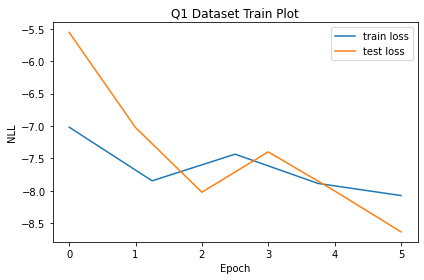

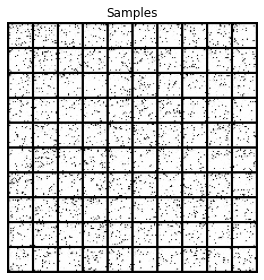

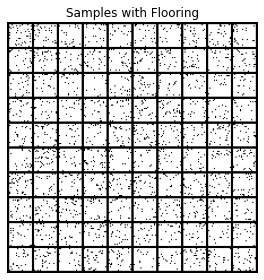

In [26]:
q1_save_results(q1)